In [1]:
import copy
import sys
import math
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn import preprocessing

from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, RandomForestClassifier
from sklearn.neural_network import MLPRegressor
from sklearn.feature_selection import SelectFromModel

%matplotlib inline
pd.set_option('display.max_colwidth', -1)
np.set_printoptions(threshold=sys.maxsize)


plt.rc('axes', titlesize=16)     # fontsize of the axes title
plt.rc('axes', labelsize=16)    # fontsize of the x and y labels


# read CSVs
X = pd.read_csv("JNSM_KV_periodic_1/X.csv")
Y = pd.read_csv("JNSM_KV_periodic_1/Y.csv")

/var/folders/bn/nlxyqghd34g5_d472cv8mbn40000gn/T/ipykernel_3879/1487877910.py:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
def preprocess(x, method, axis):
    X_preprocessed = pd.DataFrame()
    
    # select method
    if method == "normalize":        
        if axis == "row":
            X_tmp = preprocessing.normalize(x, norm='l2', axis=1)
        elif axis == "column":
            X_tmp = preprocessing.normalize(x, norm='l2', axis=0)
    elif method == "scale":
        if axis == "row":
            X_tmp = preprocessing.MinMaxScaler().fit_transform(x.T).T
        elif axis == "column":
            X_tmp = preprocessing.MinMaxScaler().fit_transform(x)
    elif method == "standardize":
        if axis == "row":
            X_tmp = preprocessing.StandardScaler().fit_transform(x.T).T
        elif axis == "column":
            X_tmp = preprocessing.StandardScaler().fit_transform(x)    
    else:
        X_tmp = x.to_numpy()
    
    for i, n in enumerate(x):
        X_preprocessed[n] = X_tmp[:, i]
    return X_preprocessed    


# outlier rejection
def outlier_remove(x, y, t):    
    to_drop = []
    for i in x:
        for j in range(len(x[i])):
            if j not in to_drop and abs(x[i][j]) > t:
                to_drop.append(j)
#     print(len(to_drop))
    x_clean = x.drop(labels=to_drop, axis=0, inplace=False)
    y_clean = y.drop(labels=to_drop, axis=0, inplace=False)
    return x_clean, y_clean, len(to_drop)


def split(x, y):    
    x_train_tmp, x_test, y_train_tmp, y_test = train_test_split(x, y, shuffle=False, random_state=0, test_size=0.3)
    x_train, y_train = shuffle(x_train_tmp, y_train_tmp, random_state=0)
    return x_train, x_test, y_train, y_test
# print(split(X_df, Y_df))


def train_and_test(x_train, x_test, y_train, y_test, model):
    if model == "regression":
        model = linear_model.LinearRegression()
    elif model == "randomforest":
        model = RandomForestRegressor(n_estimators=500, verbose=0)
    elif model == "neural":
        model = MLPRegressor(hidden_layer_sizes=[200, 100], max_iter=5000, activation="tanh", verbose=False)
    else:
        print("Unknown model")
        
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    
    naive_read, naive_write = (y_test.to_numpy().mean(axis=0)) 
    nmae_read = (1/naive_read) * mean_absolute_error(y_test.to_numpy()[:, 0], y_pred[:, 0])
    nmae_write = (1/naive_write) * mean_absolute_error(y_test.to_numpy()[:, 1], y_pred[:, 1])
    
    return (y_pred, nmae_read, nmae_write, naive_read, naive_write)


def plot(y_test, y_pred, naive_read, naive_write, ts=True, test_density=False, error_density=False):   
    # time series
    if ts:
        plt.rc('font', size=12)
        fig, ax1 = plt.subplots(figsize=(15, 8))
        time = [i for i in range(len(y_test))]
        ax1.plot(time, y_test[:, 0], color='tab:green', label='ReadsAvg measured')
        ax1.plot(time, y_pred[:, 0], color='tab:red', label='ReadsAvg predicted')
        ax1.plot(time, [naive_read]*len(y_test), color='blue', label='ReadsAvg naive baseline')
        ax1.plot(time, y_test[:, 1], color='tab:blue', label='WritesAvg measured')
        ax1.plot(time, y_pred[:, 1], color='tab:orange', label='WritesAvg predicted')
        ax1.plot(time, [naive_write]*len(y_test), color='black', label='WritesAvg naive baseline')
        ax1.set_xlabel('Time(s)')
        ax1.set_ylabel('Response time(ms)')
        ax1.set_title('Prediction of KV service')
        ax1.grid(True)
        ax1.legend(loc='upper right');

    # density and histogram 
    if test_density:
        fig, ax2 = plt.subplots(1, 2, figsize=(12, 6))
        pd.DataFrame(y_test[:, 0]).plot(kind='density', figsize=(12, 6), ax=ax2[0], title="density plot for ReadsAvg", xlabel="Response time", legend=False)
        pd.DataFrame(y_test[:, 1]).plot(kind='density', figsize=(12, 6), ax=ax2[1], title="density polt for WritesAvg", xlabel="Response time", legend=False)

        fig, ax3 = plt.subplots(1, 2, figsize=(12, 6))
        ax3[0].hist(y_test[:, 0], bins=100)
        ax3[0].set_title('Distribution of response times (ReadsAvg)')
        ax3[0].set_xlabel('response time (ms)')
        ax3[0].set_ylabel('number of samples')
        ax3[0].grid(True)
        ax3[1].hist(y_test[:, 1], bins=200)
        ax3[1].set_title('Distribution of response times (WritesAvg)')
        ax3[1].set_xlabel('response time (ms)')
        ax3[1].set_ylabel('number of samples')
        ax3[1].grid(True)

    # denisty plot of predicted errors
    if error_density:
        a = pd.DataFrame(y_test[:,0] - y_pred[:,0]).plot(kind='density', figsize=(12, 6), title="Density plot for errors in predicted response time (ReadsAvg)", xlabel="error in response time(ms)", legend=False)
        a = pd.DataFrame(y_test[:,1] - y_pred[:,1]).plot(kind='density', figsize=(12, 6), title="Density plot for errors in predicted response time (WritesAvg)", xlabel="error in response time(ms)", legend=False)
        
    plt.show()

After removing the timestamp and index: (X, Y) (14481, 1751) (14481, 2)
After preprocessing: (X) (14481, 1751)
Number of dropped samples:  [3894, 1134, 510, 366, 253, 206, 155, 121, 71, 57]


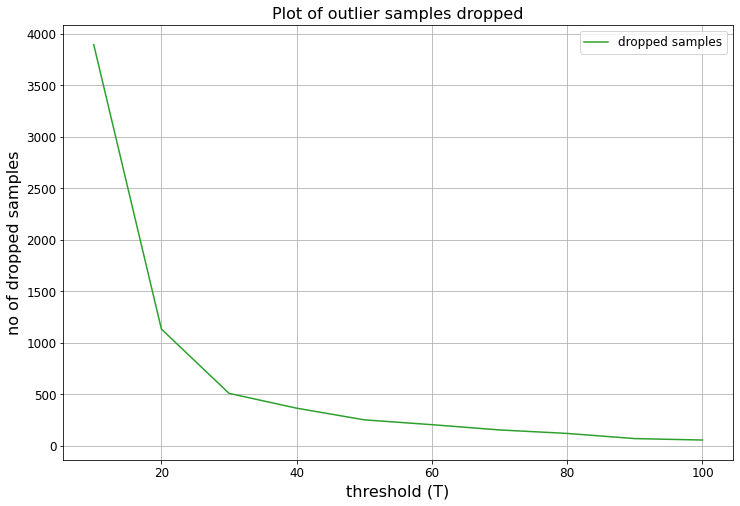

In [4]:
X_dropped = X.drop(labels=["Unnamed: 0", "TimeStamp"], axis=1, inplace=False)
Y_dropped = Y.drop(labels=["Unnamed: 0", "TimeStamp"], axis=1, inplace=False)
print("After removing the timestamp and index: (X, Y)", X_dropped.shape, Y_dropped.shape)


# preprocess
X_preprocessed = preprocess(X_dropped, method="standardize", axis="column")
print("After preprocessing: (X)", X_preprocessed.shape)


# outlier removal
thresholds = []
dropped_samples = []
cleaned_Xs, cleaned_Ys = [], []
for thresh in range(10, 110, 10):
    X_clean, Y_clean, dropped = outlier_remove(X_preprocessed, Y_dropped, t=thresh)
    thresholds.append(thresh)
    dropped_samples.append(dropped)
    cleaned_Xs.append(copy.deepcopy(X_clean))
    cleaned_Ys.append(copy.deepcopy(Y_clean))
print("Number of dropped samples: ", dropped_samples)
    

# plot the graph
# time series
plt.rc('font', size=12)
fig, ax5 = plt.subplots(figsize=(12, 8))
ax5.plot(thresholds, dropped_samples, color='tab:green', label='dropped samples')
ax5.set_xlabel('threshold (T)')
ax5.set_ylabel('no of dropped samples')
ax5.set_title('Plot of outlier samples dropped')
ax5.grid(True)
ax5.legend(loc='upper right');

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   13.9s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:  2.0min
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:  5.1min
[Parallel(n_jobs=20)]: Done 500 out of 500 | elapsed:  6.2min finished


Top Features: 
['5_i141_intr.s', '4_TxPacktes', '15_TxBytes', '29_RxPacktes', '29_TxPacktes', '29_TxBytes', '30_RxPacktes', '30_TxPacktes', '30_RxBytes', '17_RxBytes.1', '29_RxPacktes.1', '29_TxBytes.1', '30_RxPacktes.1', '30_TxPacktes.1', '30_RxBytes.1', '41_TxPacktes.1']
New design matrix shape: 
(14481, 16)
Correlation Matrix: 


/usr/local/lib/python3.9/site-packages/sklearn/base.py:438: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


                5_i141_intr.s  4_TxPacktes  15_TxBytes  29_RxPacktes  \
5_i141_intr.s   1.000000       0.885727     0.890317    0.888307       
4_TxPacktes     0.885727       1.000000     0.987075    0.993388       
15_TxBytes      0.890317       0.987075     1.000000    0.986706       
29_RxPacktes    0.888307       0.993388     0.986706    1.000000       
29_TxPacktes    0.886339       0.993571     0.987232    0.998391       
29_TxBytes      0.891327       0.986657     0.992175    0.989766       
30_RxPacktes    0.886348       0.993580     0.987275    0.998233       
30_TxPacktes    0.888444       0.993397     0.986740    0.999903       
30_RxBytes      0.888735       0.989788     0.989771    0.993778       
17_RxBytes.1    0.887659       0.990240     0.997380    0.990387       
29_RxPacktes.1  0.888307       0.993388     0.986706    1.000000       
29_TxBytes.1    0.891327       0.986657     0.992175    0.989766       
30_RxPacktes.1  0.886348       0.993580     0.987275    0.998233

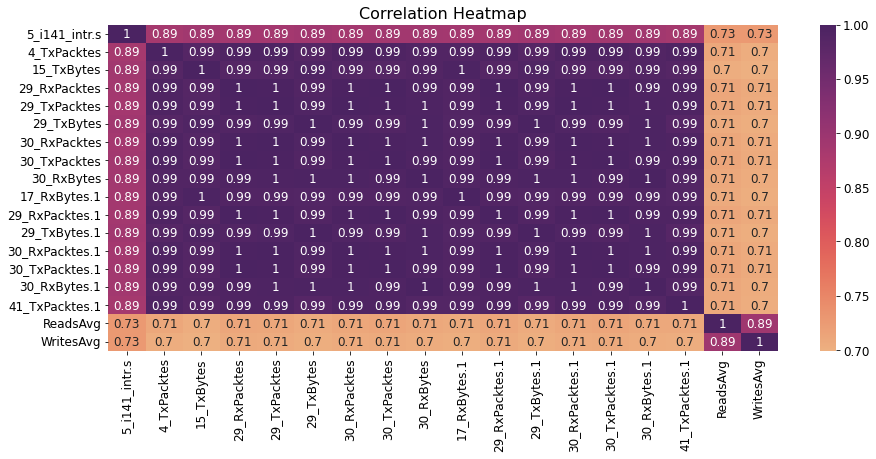

In [5]:
# select the best features using tree based method
tree_decision = ExtraTreesRegressor(n_estimators=500, verbose=1, n_jobs=20)
tree_decision = tree_decision.fit(X_preprocessed, Y_dropped)
selector = SelectFromModel(tree_decision, max_features=16, prefit=True, threshold=-np.inf)
im_features = []
f = selector.get_support()
for i, name in enumerate(X_dropped):
    if f[i]:
        im_features.append(name)
print("Top Features: ")
print(im_features)

# transform the old X to X_new
X_new = selector.transform(X_preprocessed)
print("New design matrix shape: ")
print(X_new.shape)


rel_df = pd.DataFrame()
# add X_new to a new dataframe
for i, feature_name in enumerate(im_features):
    rel_df[feature_name] = X_new[:, i]
# add Y_dropper to a new dataframe
for i, feature_name in enumerate(Y_dropped):
    rel_df[feature_name] = Y_dropped[feature_name]
# print(rel_df)

corrMatrix = rel_df.corr()
print("Correlation Matrix: ")
print(corrMatrix)

plt.figure(figsize = (15, 6))
ax = plt.axes()
sns.heatmap(corrMatrix, ax=ax, cmap="flare", annot=True)
ax.set_title('Correlation Heatmap')
plt.show()

0
1
2
3
4
5
6
7
8
9


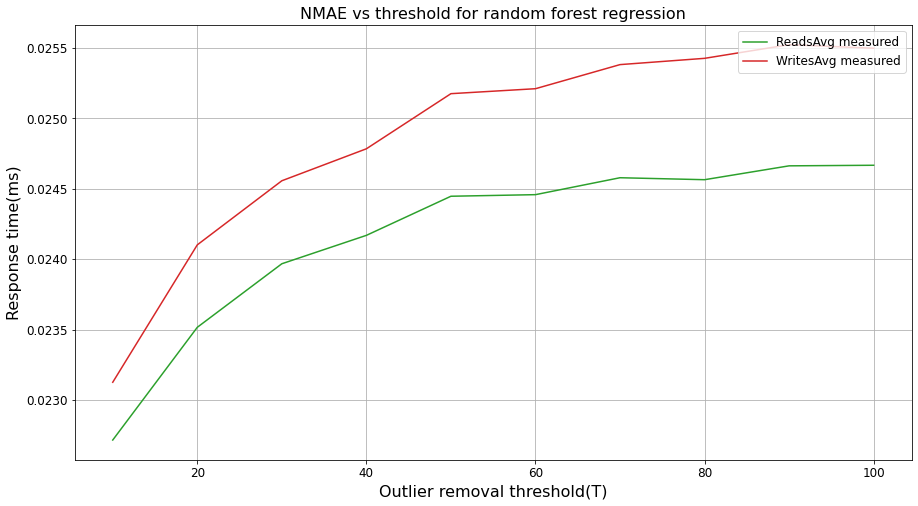

In [6]:
# print(cleaned_Xs[0]["29_TxPacktes.1"])


trained_models = []
for i in range(len(cleaned_Xs)):
    x_tmp, y_tmp = pd.DataFrame(), pd.DataFrame()
    for j, feature_name in enumerate(cleaned_Xs[i]):
        if feature_name in im_features:
            x_tmp[feature_name] = cleaned_Xs[i][feature_name]      
    for j, feature_name in enumerate(cleaned_Ys[i]):
        y_tmp[feature_name] = cleaned_Ys[i][feature_name]
    
#     print (y_tmp)
    x_train, x_test, y_train, y_test = split(x_tmp, y_tmp)
    tmp = train_and_test(x_train, x_test, y_train, y_test, model="randomforest")
    trained_models.append(copy.deepcopy(tmp))
    print(i)
    
# print(trained_models)


plt.rc('font', size=12)
fig, ax1 = plt.subplots(figsize=(15, 8))
ax1.plot(thresholds, [i[1] for i in trained_models], color='tab:green', label='ReadsAvg measured')
ax1.plot(thresholds, [i[2] for i in trained_models], color='tab:red', label='WritesAvg measured')
ax1.set_xlabel('Outlier removal threshold(T)')
ax1.set_ylabel('Response time(ms)')
ax1.set_title('NMAE vs threshold for random forest regression')
ax1.legend(loc='upper right');
ax1.grid(True)

In [7]:
X_df, Y_df = pd.DataFrame(), pd.DataFrame()

for i, feature_name in enumerate(im_features):
    X_df[feature_name] = X_new[:, i]
for i, feature_name in enumerate(Y_dropped):
    Y_df[feature_name] = Y_dropped[feature_name]


# split dataset
X_train, X_test, Y_train, Y_test = split(X_df, Y_df)


# test various methods
for axis in ["row", "column"]:
    for prep in ["standardize", "unpreprocessed", "normalize", "scale"]:
        X_train_preprocess = preprocess(X_train, method=prep, axis=axis)
        X_test_preprocess = preprocess(X_test, method=prep, axis=axis)
        for model in ["neural", "randomforest", "regression", ]:
            x = train_and_test(X_train_preprocess, X_test_preprocess, Y_train, Y_test, model=model)
            print(axis, prep, model, ":")
            print ("Normalized mean absolute error [ReadAvg, WriteAvg]: %.3g %.3g" % (x[1], x[2]))
            print ("Naive estimator [ReadAvg, WriteAvg]: %.3g %.3g" % (x[3], x[4]))
#             plot(Y_test.to_numpy(), x[0], x[3], x[4])
            print()
        print()
        print()

row standardize neural :
Normalized mean absolute error [ReadAvg, WriteAvg]: 0.0483 0.0502
Naive estimator [ReadAvg, WriteAvg]: 56.4 113

row standardize randomforest :
Normalized mean absolute error [ReadAvg, WriteAvg]: 0.037 0.0387
Naive estimator [ReadAvg, WriteAvg]: 56.4 113

row standardize regression :
Normalized mean absolute error [ReadAvg, WriteAvg]: 0.0465 0.0482
Naive estimator [ReadAvg, WriteAvg]: 56.4 113



row unpreprocessed neural :
Normalized mean absolute error [ReadAvg, WriteAvg]: 0.0244 0.025
Naive estimator [ReadAvg, WriteAvg]: 56.4 113

row unpreprocessed randomforest :
Normalized mean absolute error [ReadAvg, WriteAvg]: 0.025 0.0259
Naive estimator [ReadAvg, WriteAvg]: 56.4 113

row unpreprocessed regression :
Normalized mean absolute error [ReadAvg, WriteAvg]: 0.0278 0.0284
Naive estimator [ReadAvg, WriteAvg]: 56.4 113



row normalize neural :
Normalized mean absolute error [ReadAvg, WriteAvg]: 0.0298 0.0303
Naive estimator [ReadAvg, WriteAvg]: 56.4 113

row no

column scale regression :
Normalized mean absolute error [ReadAvg, WriteAvg]: 0.0341 0.0355
Naive estimator [ReadAvg, WriteAvg]: 56.4 113


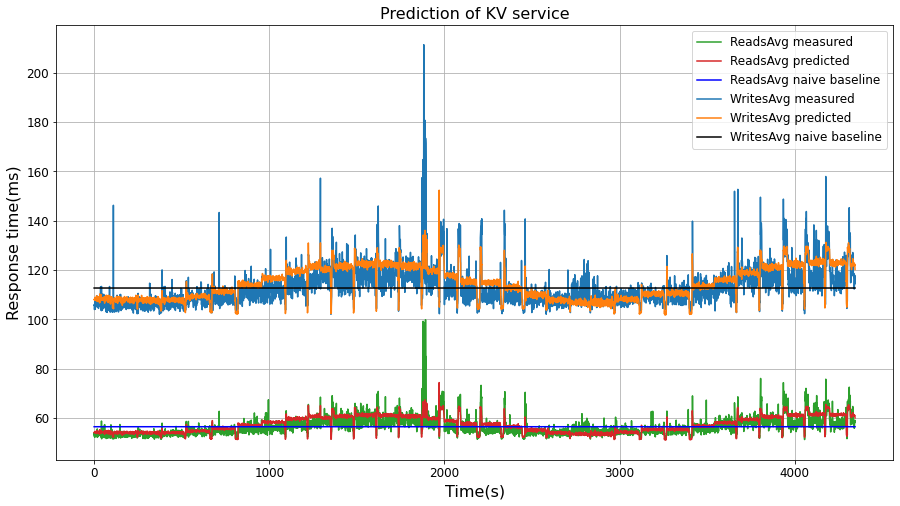

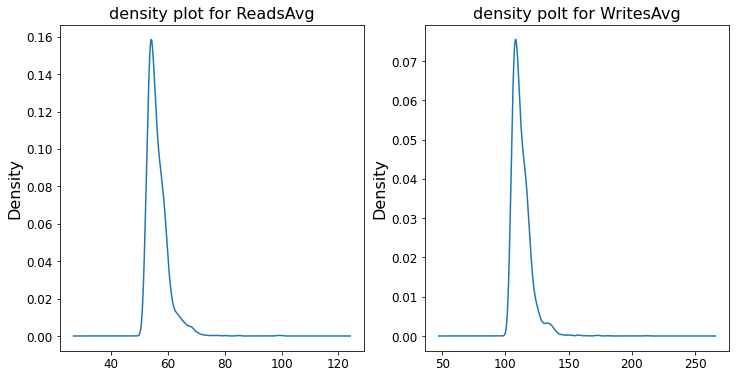

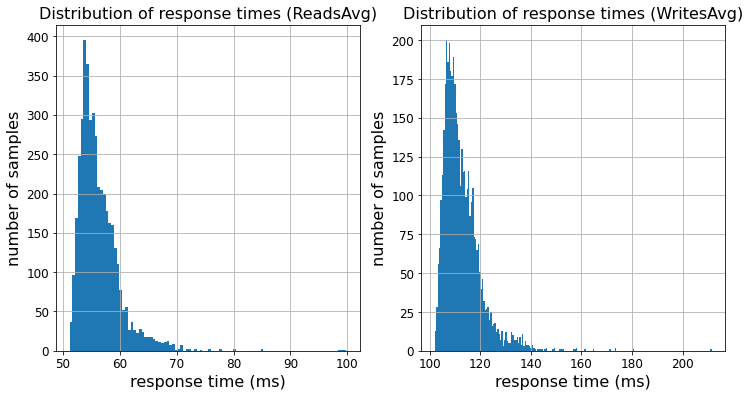

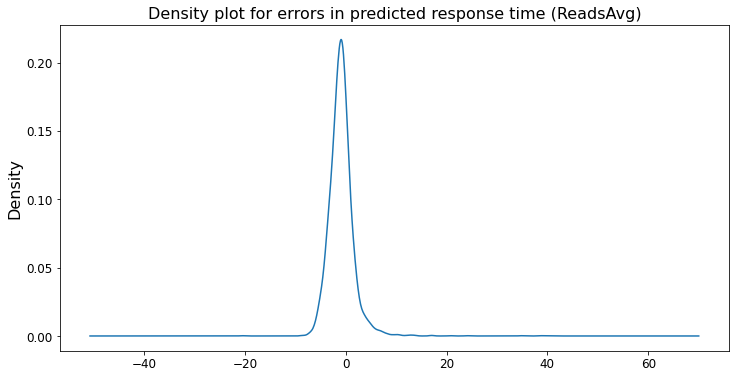

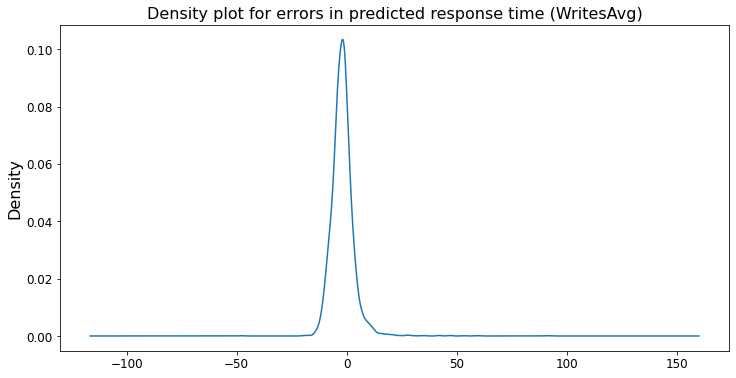


column scale randomforest :
Normalized mean absolute error [ReadAvg, WriteAvg]: 0.0402 0.0448
Naive estimator [ReadAvg, WriteAvg]: 56.4 113


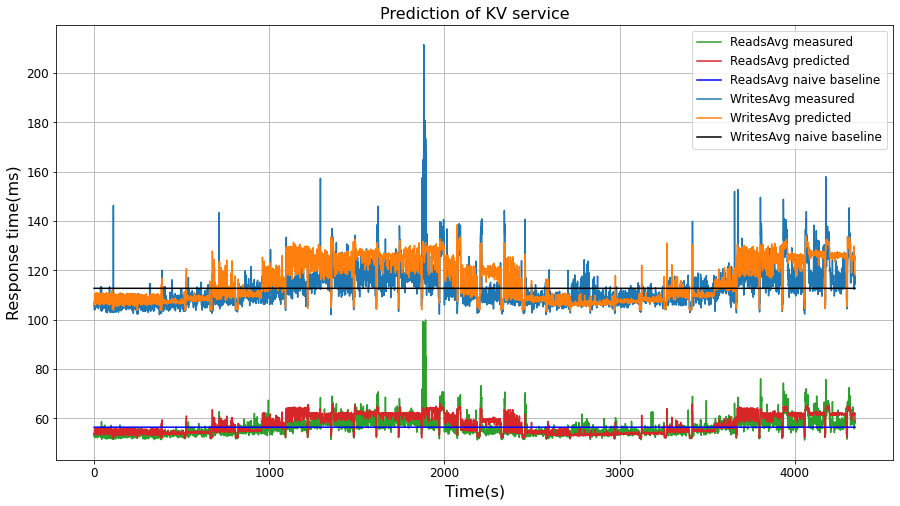

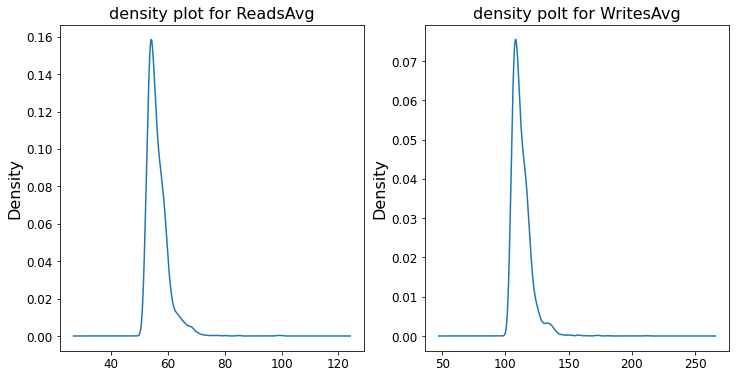

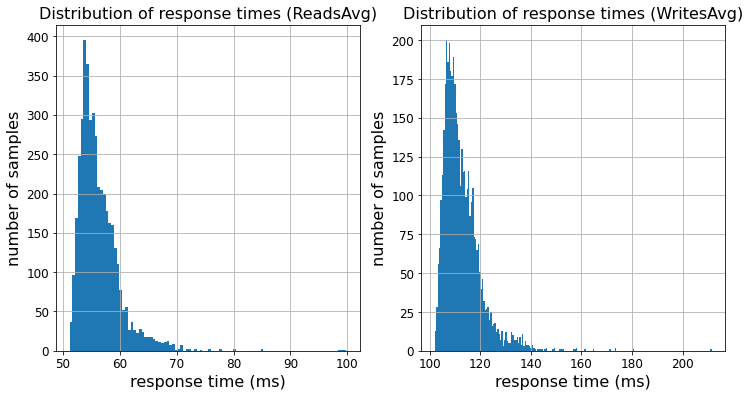

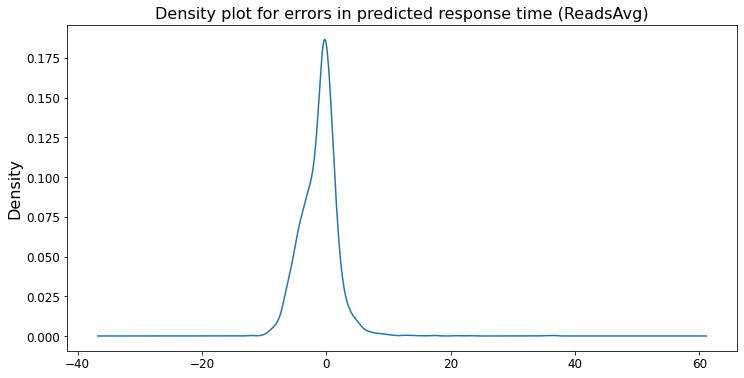

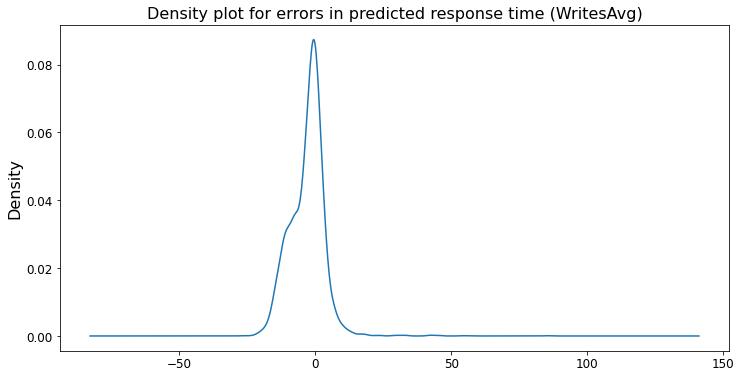


column scale neural :
Normalized mean absolute error [ReadAvg, WriteAvg]: 0.0348 0.0372
Naive estimator [ReadAvg, WriteAvg]: 56.4 113


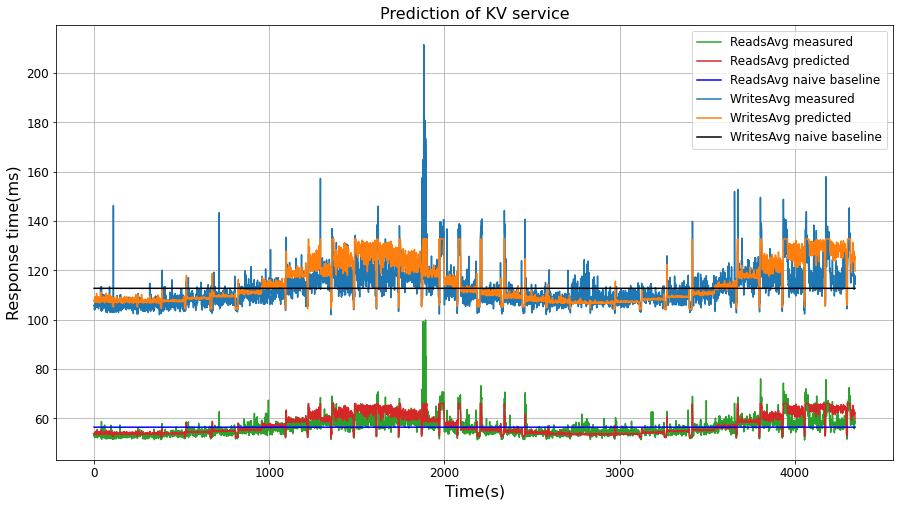

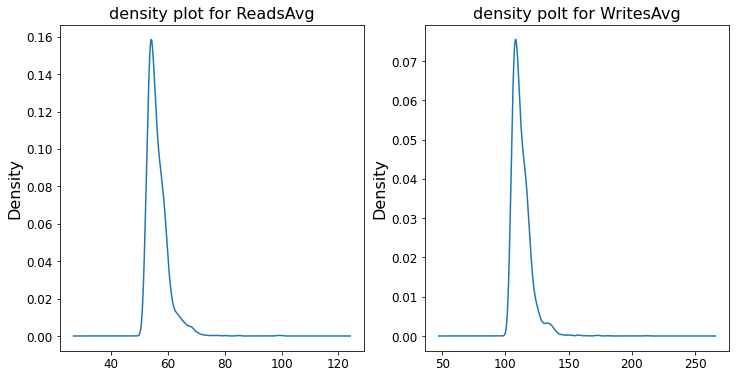

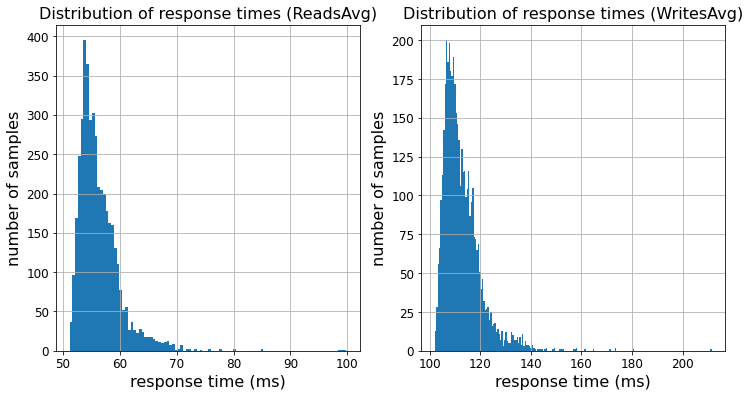

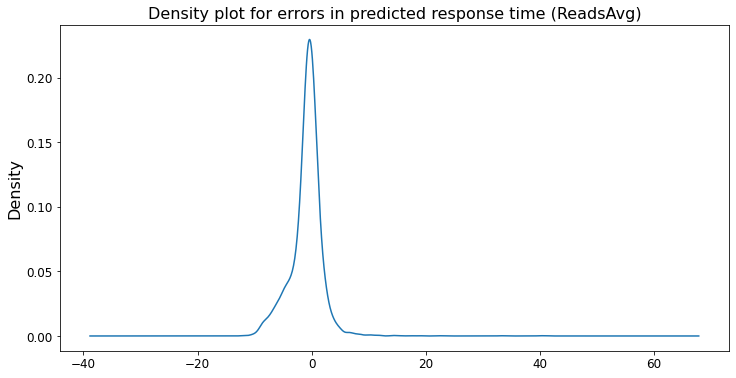

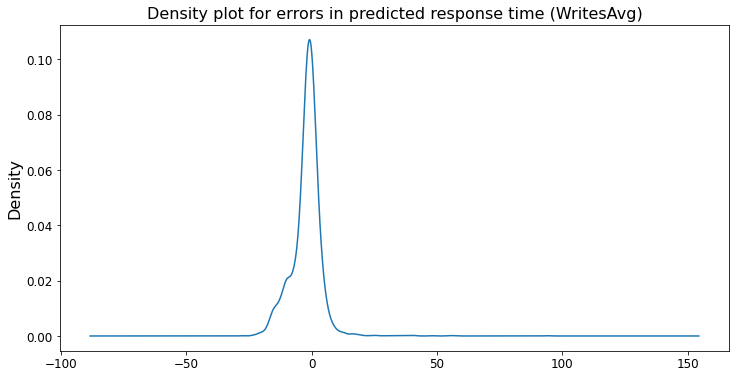

In [8]:
X_train_scaled = preprocess(X_train, method="scale", axis="column")
X_test_scaled = preprocess(X_test, method="scale", axis="column")
for model in ["regression", "randomforest", "neural"]:
    x = train_and_test(X_train_scaled, X_test_scaled, Y_train, Y_test, model=model)
    print(axis, prep, model, ":")
    print ("Normalized mean absolute error [ReadAvg, WriteAvg]: %.3g %.3g" % (x[1], x[2]))
    print ("Naive estimator [ReadAvg, WriteAvg]: %.3g %.3g" % (x[3], x[4]))
    plot(Y_test.to_numpy(), x[0], x[3], x[4], test_density=True, error_density=True)
    print()

After preprocessing: (X) (14481, 1751)
(10052, 1751) (4308, 1751) (10052, 2) (4308, 2)
50.6874 105.1628 101.4406 206.7051
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 14.0, 19.0}
{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 14.0, 19.0}


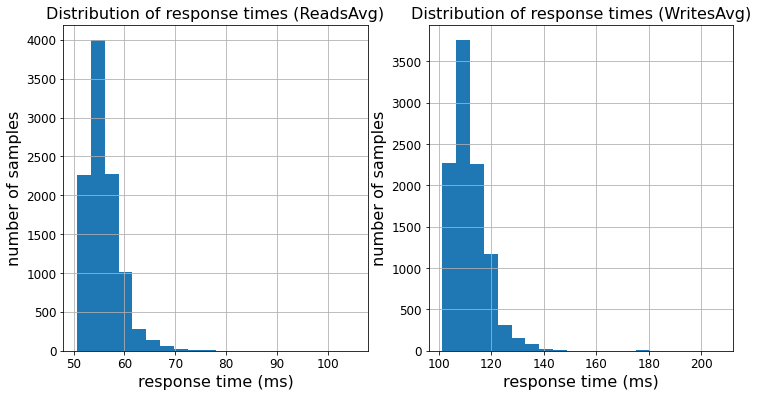

In [9]:
X_df, Y_df = pd.DataFrame(), pd.DataFrame()

X_preprocessed = preprocess(X_dropped, method="standardize", axis="column")
print("After preprocessing: (X)", X_preprocessed.shape)

for i, feature_name in enumerate(im_features):
    X_df[feature_name] = X_preprocessed[feature_name]
for i, feature_name in enumerate(Y_dropped):
    Y_df[feature_name] = Y_dropped[feature_name]


# oulier removal
X_clean, Y_clean, dropped = outlier_remove(X_preprocessed, Y_dropped, t=80)


# split dataset
X_train, X_test, Y_train, Y_test = split(X_clean, Y_clean)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)


min_reads_avg = np.min(Y_train["ReadsAvg"])
max_reads_avg = np.max(Y_train["ReadsAvg"])
min_writes_avg = np.min(Y_train["WritesAvg"])
max_writes_avg = np.max(Y_train["WritesAvg"])
print(min_reads_avg, max_reads_avg, min_writes_avg, max_writes_avg)

fig, ax7 = plt.subplots(1, 2, figsize=(12, 6))
a = ax7[0].hist(Y_train["ReadsAvg"], bins=20)
ax7[0].set_title('Distribution of response times (ReadsAvg)')
ax7[0].set_xlabel('response time (ms)')
ax7[0].set_ylabel('number of samples')
ax7[0].grid(True)
b = ax7[1].hist(Y_train["WritesAvg"], bins=20)
ax7[1].set_title('Distribution of response times (WritesAvg)')
ax7[1].set_xlabel('response time (ms)')
ax7[1].set_ylabel('number of samples')
ax7[1].grid(True)

# print(a)
binner = preprocessing.KBinsDiscretizer(n_bins=20, strategy="uniform", encode="ordinal")
Y_train_binned = binner.fit_transform(Y_train)
Y_test_binned = binner.fit_transform(Y_test)
print(set(list(Y_train_binned[:, 0])))
print(set(list(Y_train_binned[:, 1])))

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.6s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    4.3s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:   11.1s
[Parallel(n_jobs=20)]: Done 500 out of 500 | elapsed:   13.4s finished
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.3s
[Parallel(n_jobs=20)]: Done 500 out of 500 | elapsed:    0.4s finished


Naive Estimator(ReadsAvg, WritesAvg) 54.3 109
NMAE(ReadsAvg, WritesAvg) 0.0413 0.0366


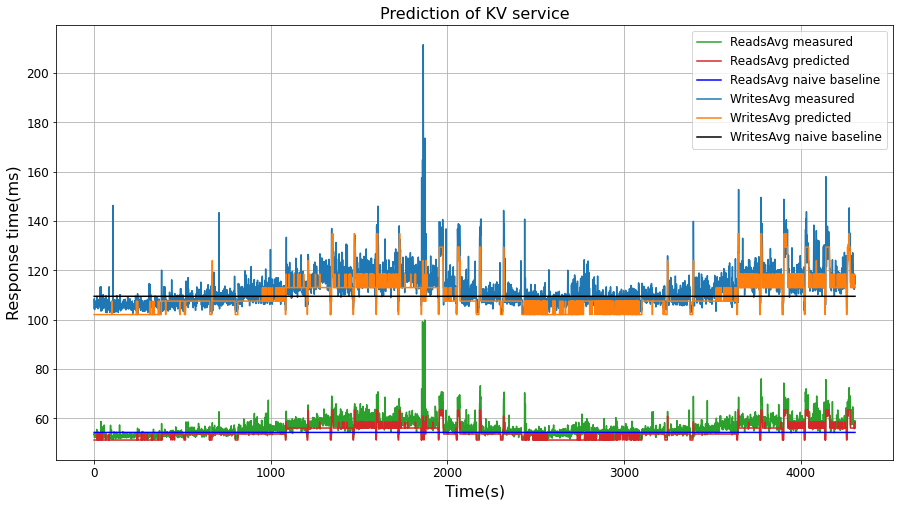

[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.1s
[Parallel(n_jobs=20)]: Done 500 out of 500 | elapsed:    0.1s finished
/usr/local/lib/python3.9/site-packages/sklearn/base.py:445: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
[Parallel(n_jobs=20)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 160 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 410 tasks      | elapsed:    0.0s
[Parallel(n_jobs=20)]: Done 500 out of 500 | elapsed:    0.1s finished
No handles with labels found to put in legend.
No handles with labels found to put in legend.


sample prediction
[[1. 1.]
 [1. 1.]]


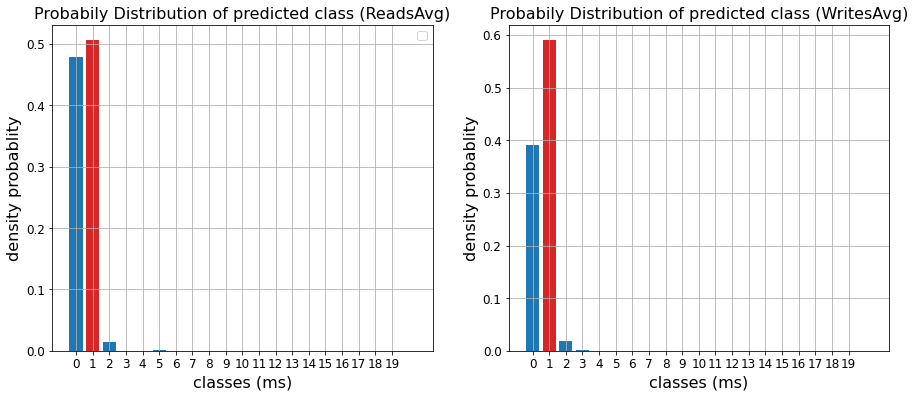

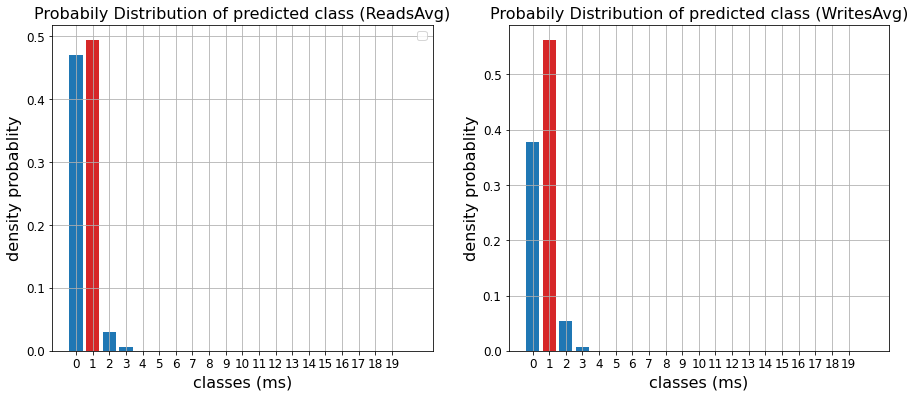

In [14]:
# train model
m = RandomForestClassifier(n_estimators=500, verbose=1, n_jobs=20, random_state=0)
m.fit(X_train, Y_train_binned)
y_pred = m.predict(X_test)


# compute nmae
y_pred_read, y_pred_write = [], []
for i in y_pred:
    y_pred_read.append(binner.bin_edges_[0][int(i[0])])
    y_pred_write.append(binner.bin_edges_[1][int(i[1])])
naive_read, naive_write = np.mean(y_pred_read), np.mean(y_pred_write) 
nmae_read = (1/naive_read) * mean_absolute_error(Y_test.to_numpy()[:, 0], y_pred_read)
nmae_write = (1/naive_write) * mean_absolute_error(Y_test.to_numpy()[:, 1], y_pred_write)
print("Naive Estimator(ReadsAvg, WritesAvg) %.3g %.3g" % (naive_read, naive_write))
print("NMAE(ReadsAvg, WritesAvg) %.3g %.3g" % (nmae_read, nmae_write))


tmp = np.array([(y_pred_read[i], y_pred_write[i]) for i,_ in enumerate(y_pred_read)])
plot(Y_test.to_numpy(), tmp, naive_read, naive_write, ts=True, test_density=False, error_density=False)

    
# plot density distribution
N_classes = 20
classes = m.classes_
sample = X_test[:][500:502]
y_pred_sample = m.predict(sample)
print("sample prediction")
print(y_pred_sample)

sample_run = m.predict_proba(sample.to_numpy())
# print (sample_run)
prob = []
for i, _ in enumerate(sample_run):    
    tmp = dict(zip(classes[0],sample_run[i][0]))
    tmp1 = dict(zip(classes[1],sample_run[i][1]))
    for i in np.arange(0.0, 21.0, 1.0):
        if i not in tmp:
            tmp.update({i: 0.0})
        if i not in tmp1:
            tmp1.update({i: 0.0})
            
#     print(tmp)
    colors = ["tab:blue"]*20
    colors[1] = "tab:red"
    fig, ax8 = plt.subplots(1, 2, figsize=(15, 6))
    ax8[0].bar([i for i in tmp], [tmp[i] for i in tmp], color=colors)
    ax8[0].set_title('Probabily Distribution of predicted class (ReadsAvg)')
    ax8[0].set_xlabel('classes (ms)')
    ax8[0].set_ylabel('density probablity')
    ax8[0].set_xticks(range(0, 20, 1))
    ax8[0].grid(True)
    ax8[0].legend(loc='upper right')
    ax8[1].bar([i for i in tmp1], [tmp1[i] for i in tmp1], color=colors)
    ax8[1].set_title('Probabily Distribution of predicted class (WritesAvg)')
    ax8[1].set_xlabel('classes (ms)')
    ax8[1].set_ylabel('density probablity')
    ax8[1].set_xticks(range(0, 20, 1))
    ax8[1].grid(True)

ReadsAvg 95th:  60.67455666666666 0.9496617588539594
ReadsAvg 50th:  54.31909333333333 0.5294468762435336
ReadsAvg 20th:  52.50324666666666 0.22532829287703937

ReadsAvg 95th:  122.4935 0.9563270990847593
ReadsAvg 50th:  108.45823333333334 0.5107441305212893
ReadsAvg 20th:  104.94941666666666 0.22562674094707522


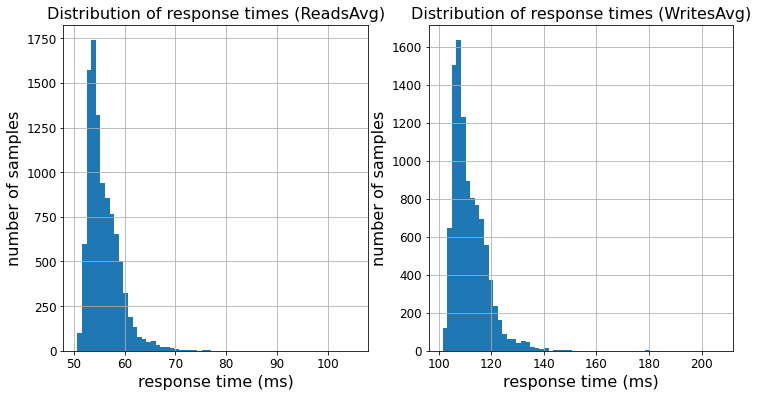

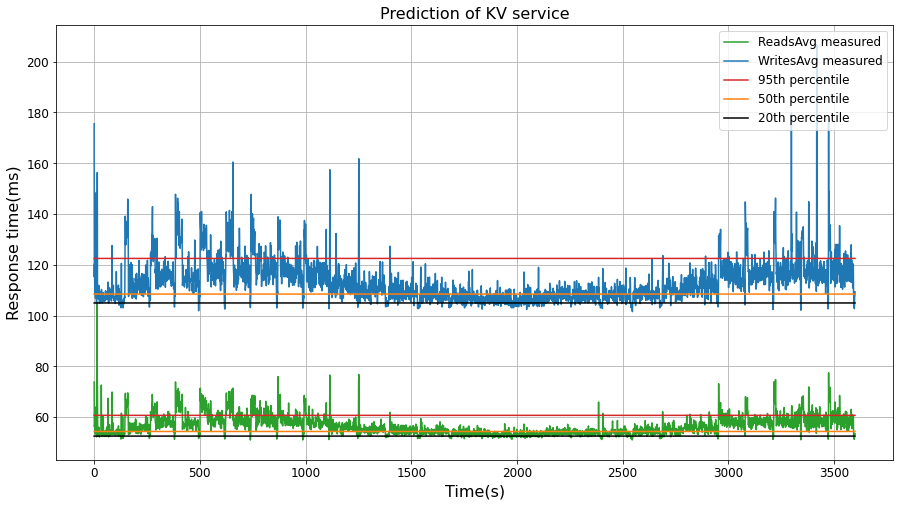

In [128]:
fig, ax8 = plt.subplots(1, 2, figsize=(12, 6))
reads_binned = ax8[0].hist(Y_train["ReadsAvg"], bins=60)
ax8[0].set_title('Distribution of response times (ReadsAvg)')
ax8[0].set_xlabel('response time (ms)')
ax8[0].set_ylabel('number of samples')
ax8[0].grid(True)
writes_binned = ax8[1].hist(Y_train["WritesAvg"], bins=60)
ax8[1].set_title('Distribution of response times (WritesAvg)')
ax8[1].set_xlabel('response time (ms)')
ax8[1].set_ylabel('number of samples')
ax8[1].grid(True)

reads_n_samples = np.sum(reads_binned[0])
reads_freq = [(i/reads_n_samples) for i in reads_binned[0]]
# print(reads_n_samples, reads_freq)

writes_n_samples = np.sum(writes_binned[0])
writes_freq = [(i/writes_n_samples) for i in writes_binned[0]]
# print(writes_n_samples, writes_freq)

print("ReadsAvg 95th: ", reads_binned[1][11], np.sum(reads_freq[:12]))
print("ReadsAvg 50th: ", reads_binned[1][4], np.sum(reads_freq[:5]))
print("ReadsAvg 20th: ", reads_binned[1][2], np.sum(reads_freq[:3]))
print()
print("WritesAvg 95th: ", writes_binned[1][12], np.sum(writes_freq[:13]))
print("WritesAvg 50th: ", writes_binned[1][4], np.sum(writes_freq[:5]))
print("WritesAvg 20th: ", writes_binned[1][2], np.sum(writes_freq[:3]))


one_hour_data = Y_dropped[:3600]


plt.rc('font', size=12)
fig, ax1 = plt.subplots(figsize=(15, 8))
time = [i for i in range(len(one_hour_data))]
ax1.plot(time, one_hour_data["ReadsAvg"], color='tab:green', label='ReadsAvg measured')
ax1.plot(time, one_hour_data["WritesAvg"], color='tab:blue', label='WritesAvg measured')

ax1.plot(time, [reads_binned[1][11]]*len(time), color='tab:red', label='95th percentile')
ax1.plot(time, [reads_binned[1][4]]*len(time), color='tab:orange', label='50th percentile')
ax1.plot(time, [reads_binned[1][2]]*len(time), color='black', label='20th percentile')

ax1.plot(time, [writes_binned[1][12]]*len(time), color='tab:red')
ax1.plot(time, [writes_binned[1][4]]*len(time), color='tab:orange')
ax1.plot(time, [writes_binned[1][2]]*len(time), color='black')

ax1.set_xlabel('Time(s)')
ax1.set_ylabel('Response time(ms)')
ax1.set_title('Prediction of KV service')
ax1.grid(True)
ax1.legend(loc='upper right');

ReadsAvg 95th:  62.535246666666666 0.9512534818941505
ReadsAvg 50th:  55.236666666666665 0.5710306406685236
ReadsAvg 20th:  52.80380666666667 0.19452181987000927

WritesAvg 95th:  125.75053 0.9589136490250696
WritesAvg 50th:  109.33803999999999 0.5157845868152275
WritesAvg 20th:  105.69082 0.2488393686165274

20th percentile estimation [ReadsAvg: 0.0882, WritesAvg: 0.109]
50th percentile estimation [ReadsAvg: 0.464, WritesAvg: 0.39]
95th percentile estimation [ReadsAvg: 0.942, WritesAvg: 0.948]


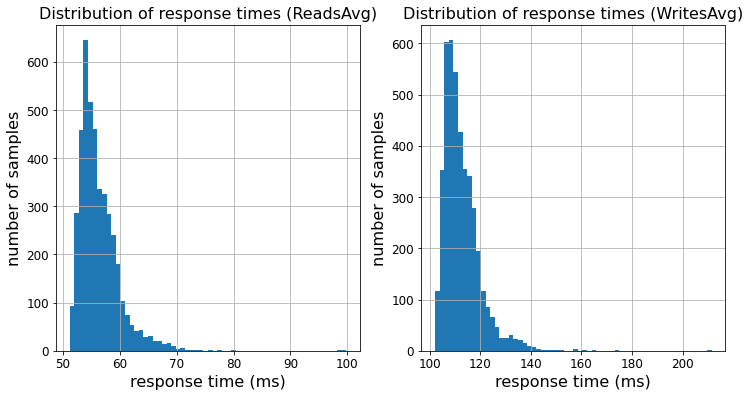

In [185]:
fig, ax8 = plt.subplots(1, 2, figsize=(12, 6))
reads_binned = ax8[0].hist(Y_test["ReadsAvg"], bins=60)
ax8[0].set_title('Distribution of response times (ReadsAvg)')
ax8[0].set_xlabel('response time (ms)')
ax8[0].set_ylabel('number of samples')
ax8[0].grid(True)
writes_binned = ax8[1].hist(Y_test["WritesAvg"], bins=60)
ax8[1].set_title('Distribution of response times (WritesAvg)')
ax8[1].set_xlabel('response time (ms)')
ax8[1].set_ylabel('number of samples')
ax8[1].grid(True)

reads_n_samples = np.sum(reads_binned[0])
reads_freq = [(i/reads_n_samples) for i in reads_binned[0]]
# print(reads_n_samples, reads_freq)

writes_n_samples = np.sum(writes_binned[0])
writes_freq = [(i/writes_n_samples) for i in writes_binned[0]]
# print(writes_n_samples, writes_freq)


rds_perc95_bin, rds_perc95_val = reads_binned[1][14], np.sum(reads_freq[:15])
rds_perc50_bin, rds_perc50_val = reads_binned[1][5], np.sum(reads_freq[:6])
rds_perc20_bin, rds_perc20_val = reads_binned[1][2], np.sum(reads_freq[:3])

wts_perc95_bin, wts_perc95_val = writes_binned[1][13], np.sum(writes_freq[:14])
wts_perc50_bin, wts_perc50_val = writes_binned[1][4], np.sum(writes_freq[:5])
wts_perc20_bin, wts_perc20_val = writes_binned[1][2], np.sum(writes_freq[:3])

print("ReadsAvg 95th: ", rds_perc95_bin, rds_perc95_val)
print("ReadsAvg 50th: ", rds_perc50_bin, rds_perc50_val)
print("ReadsAvg 20th: ", rds_perc20_bin, rds_perc20_val)
print()
print("WritesAvg 95th: ", wts_perc95_bin, wts_perc95_val)
print("WritesAvg 50th: ", wts_perc50_bin, wts_perc50_val)
print("WritesAvg 20th: ", wts_perc20_bin, wts_perc20_val)


print()
Y_test_reset = Y_test.reset_index(drop=True)
n_samples = Y_test_reset.shape[0]
d = {"20": [rds_perc20_bin, wts_perc20_bin], "50": [rds_perc50_bin, wts_perc50_bin], "95": [rds_perc95_bin, wts_perc95_bin]}
for i in d: 
    reads = [1 if Y_test_reset["ReadsAvg"][j] <= d[i][0] else 0 for j in range(n_samples)]
    writes = [1 if Y_test_reset["WritesAvg"][j] <= d[i][1] else 0 for j in range(n_samples)]
    print("%sth percentile estimation [ReadsAvg: %.3g, WritesAvg: %.3g]" % (i, reads.count(1)/n_samples, writes.count(1)/n_samples))
    